In [7]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
import sys
import os
from torch.utils.data import DataLoader

os.environ["CUDA_VISIBLE_DEVICES"]="7"
sys.path.append("../")

from configs.baseline_effnetb7_3planes_v0 import Configs


In [28]:
from senet_hoa.callbacks.evaluation import compute_2d_dice

In [4]:
cfg = Configs()

/usr/local/lib/python3.8/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnetv2_m_in21k to current tf_efficientnetv2_m.in21k.
  model = create_fn(
/usr/local/lib/python3.8/dist-packages/torch/storage.py:315: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.
  warnings.warn(message, UserWarning)


length of train: 14800, length of valid: 513


In [24]:

import torch
from tqdm import tqdm
import os
import numpy as np
from scipy import stats
from collections import defaultdict
from senet_hoa.utils.surface_dice_metric import compute_surface_dice_at_tolerance,compute_surface_distances
from senet_hoa.dataset.segment_3d_dataset import LargeImageInferenceCollator

def compute_2d_dice(gt,pred):
    return compute_surface_dice_at_tolerance(compute_surface_distances(gt,pred,(1,1)),0)

class ModelValidationCallback:
    def __init__(self,model,valid_loader,threshold=0.5,device="cpu",output_dir="./"):
        self.model = model
        self.valid_loader = valid_loader
        self.threshold = threshold
        self.device = device
        self.output_dir = output_dir
        self.score =-1

    def __call__(self, current_step):
        # Initializing storage for overall truths and predictions
        ground_truth = []
        predictions = []
        
        for images,coors,shape,mask_gt in tqdm(self.valid_loader):
            with torch.no_grad():
                prediction = self.model(images.to(self.device)).detach().cpu()
                prediction = torch.sigmoid(LargeImageInferenceCollator.combine_masks_into_image(shape,coors,prediction))
            ground_truth.append(mask_gt.squeeze(0).numpy())
            predictions.append(prediction.squeeze(0).squeeze(1).numpy())
        return ground_truth,predictions

In [14]:
cfg.load_state_dict("/app/segment/solve-diseases/workdir/configs.baseline_effnetb7_3planes_v0/bestmodel_opa.pkl")
cfg.model.to(cfg.device)
1

1

In [25]:
valid_loader = DataLoader(cfg., batch_size=1, pin_memory=cfg.PIN_MEMORY, num_workers=cfg.NUM_WORKERS_VAL,shuffle=False,collate_fn=cfg.inference_collator)

In [26]:
evaluation_callback = ModelValidationCallback(cfg.model,valid_loader,cfg.PRED_THRESHOLD,cfg.device)


In [27]:
gt,preds = evaluation_callback(0)

100%|██████████| 513/513 [05:14<00:00,  1.63it/s]


In [29]:
all_scores = [compute_2d_dice(x>0,y>cfg.PRED_THRESHOLD) for x,y in tqdm(zip(gt,preds))] 

215it [01:28,  4.75it/s]/app/segment/solve-diseases/notebooks/../senet_hoa/utils/surface_dice_metric.py:1181: RuntimeWarning: invalid value encountered in double_scalars
  surface_dice = (overlap_gt + overlap_pred) / (np.sum(surfel_areas_gt) +
513it [02:07,  4.02it/s]


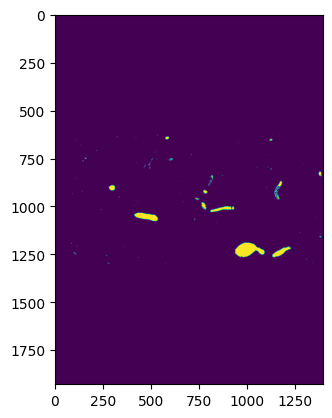

In [66]:
plt.imshow(preds[91]>0.7)

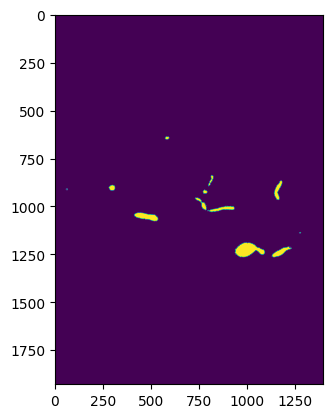

In [60]:
plt.imshow(gt[91])